In [379]:
import numpy as np
import pandas as pd
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = [16, 11]
plt.rcParams["figure.autolayout"] = True

## Load data
Here we load the data, and make sure that the entire data set is contained in one dataframe, for manual splitting. This manual splitting will later be done so that we can control the that all events used for training, will take place before the test set, avoiding the future data problem. The data will be sorted according to its time values.

In [297]:
path = r"D:/University/Year 2/Q3/DBL/Data/BPI Challenge 2012/"
df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


df_data = pd.concat([df_train, df_test])

#### Data split for demo

In [298]:
def data_split(df):
    """returns 10% of the data"""
    return df[: int((len(df)/10))]

In [299]:
# df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True).dt.date
df_data.sort_values(by=['event time:timestamp'])
df_data.reset_index(inplace=True, drop=True)
# df_data.drop(['case description', 'event org:resource'], axis=1, inplace=True)

# remove whitespace at beginning and end of column name
df_data.columns = df_data.columns.str.strip()

In [300]:
# df_data = data_split(df_data)

## Pre processing and feature engineering

In [301]:
# assign long column names to variables for easier use
cases = "case concept:name"
reg_date = "case REG_DATE"
amount_req = "case AMOUNT_REQ"
event_name = "event concept:name"
lifecycle = "event lifecycle:transition"
tmstmp = "event time:timestamp"
nxt_event = "next event"
dtime = "delta time"

In [302]:
print(f'{df_data[lifecycle].unique()[0]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[0]])}')
print(f'{df_data[lifecycle].unique()[1]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[1]])}')
print(f'{df_data[lifecycle].unique()[2]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[2]])}')

COMPLETE happens 164506
SCHEDULE happens 26318
START happens 71376


In [303]:
first_clean = df_data[df_data[lifecycle] == df_data[lifecycle].unique()[0]].copy()

In [304]:
len(df_data)

262200

In [305]:
len(df_data['eventID'].unique())

262200

In [306]:
first_clean[lifecycle].unique()

array(['COMPLETE'], dtype=object)

In [307]:
print(f'The number of unique cases/traces in the dataset is {len(first_clean[cases].unique())}')

The number of unique cases/traces in the dataset is 13087


In [308]:
lst_events = first_clean[cases].unique().tolist()

In [309]:
first_clean[nxt_event] = np.nan

In [310]:
# first_clean[first_clean[cases] == 173688]

In [311]:
# test environment
temp_data = first_clean[: 1000]
test_lst = temp_data[cases].unique().tolist()

In [312]:
def next_event(data, lst, case, nxt, name):
    """function to add the next event of a trace"""
    for i in lst:
        data.loc[data[case] == i, nxt] = data.loc[data[case] == i, name].shift(-1)
    return data

In [313]:
next_event(first_clean, lst_events, cases, nxt_event, event_name)

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,next event
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546,A_PARTLYSUBMITTED
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880,A_PREACCEPTED
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906,A_ACCEPTED
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,01-10-2011 08:08:58.256,A_PARTLYSUBMITTED
5,4294967297,173691,2011-10-01T08:08:58.256+02:00,5000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 08:09:02.195,A_PREACCEPTED
...,...,...,...,...,...,...,...,...
262190,52342766436385,211624,2012-02-21T23:38:40.044+01:00,35000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 15:56:07.999,W_Nabellen incomplete dossiers
262192,55465207660584,213855,2012-02-28T20:01:24.679+01:00,37500,W_Nabellen offertes,COMPLETE,14-03-2012 15:57:49.624,NaN
262194,53846004989989,212689,2012-02-25T11:24:12.200+01:00,2000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 15:58:57.002,NaN
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 16:00:09.680,NaN


In [314]:
# temp_data["delta"] = np.nan
# temp_data["time in seconds"] = temp_data[reg_date]

In [315]:
# tmp = temp_data[temp_data[cases] == 173688].copy()

In [316]:
# tmp

In [317]:
# temp_data.loc[temp_data[cases] == 173688, nxt_event] = temp_data.loc[temp_data[cases] == 173688, event_name].shift(-1)

In [318]:
# temp_data[temp_data[cases] == 173688]

Here we will split the data

In [319]:
from sklearn.model_selection import train_test_split

In [320]:
x = np.sort(np.random.randint(1,101,25))
y = np.sort(np.random.randint(1,101,25))

In [321]:
x, y

(array([  2,   2,   3,  15,  21,  21,  22,  24,  30,  33,  38,  52,  53,
         60,  61,  64,  72,  75,  75,  83,  87,  88,  88,  93, 100]),
 array([ 3,  7, 15, 21, 22, 39, 42, 47, 49, 51, 51, 55, 58, 59, 60, 62, 62,
        62, 64, 73, 76, 80, 89, 91, 92]))

In [322]:
# by specifying shuffle = False, it will split based the last bits as demonstrated here
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

In [323]:
X_train_t, X_test_t, y_train_t, y_test_t

(array([ 2,  2,  3, 15, 21, 21, 22, 24, 30, 33, 38, 52, 53, 60, 61, 64, 72,
        75, 75, 83]),
 array([ 87,  88,  88,  93, 100]),
 array([ 3,  7, 15, 21, 22, 39, 42, 47, 49, 51, 51, 55, 58, 59, 60, 62, 62,
        62, 64, 73]),
 array([76, 80, 89, 91, 92]))

In [324]:
first_clean

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,next event
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546,A_PARTLYSUBMITTED
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880,A_PREACCEPTED
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906,A_ACCEPTED
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,01-10-2011 08:08:58.256,A_PARTLYSUBMITTED
5,4294967297,173691,2011-10-01T08:08:58.256+02:00,5000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 08:09:02.195,A_PREACCEPTED
...,...,...,...,...,...,...,...,...
262190,52342766436385,211624,2012-02-21T23:38:40.044+01:00,35000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 15:56:07.999,W_Nabellen incomplete dossiers
262192,55465207660584,213855,2012-02-28T20:01:24.679+01:00,37500,W_Nabellen offertes,COMPLETE,14-03-2012 15:57:49.624,NaN
262194,53846004989989,212689,2012-02-25T11:24:12.200+01:00,2000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 15:58:57.002,NaN
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 16:00:09.680,NaN


In [325]:
# Xs for the decision tree
# event timestamp, but only the time of day -> transformed to time of day from column. make sure its numerical object, or encoded
# event concept name, encode needed *onehot*
# amount_req, check if its a numerical value


In [326]:
# pd.to_datetime(first_clean[tmstmp][:100], format="%H:%M:%S")

In [327]:
# test = first_clean[[tmstmp]][:100]
# # x = test[0].split()[1]

In [328]:
# test[['time_str']] = test.str.split(expand=True)[1]

In [329]:
# extract time of day
first_clean['time of day'] = first_clean[tmstmp].str.split(expand=True)[1]

In [330]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

event_encoder = LabelEncoder()
time_of_day_encoder = OrdinalEncoder()

In [331]:
labels = first_clean[event_name].unique()
event_encoder.fit(labels)
first_clean["time of day"] = time_of_day_encoder.fit_transform(first_clean[["time of day"]])

In [332]:
# event_encoder.classes_

In [333]:
# first_clean[event_name].unique()

In [334]:
first_clean[[event_name, nxt_event]] = first_clean[[event_name, nxt_event]].apply(event_encoder.fit_transform)

In [335]:
first_clean.head(10)

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,next event,time of day
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,9,COMPLETE,01-10-2011 00:38:44.546,6,332.0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,COMPLETE,01-10-2011 00:38:44.880,7,333.0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,COMPLETE,01-10-2011 00:39:37.906,0,337.0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,9,COMPLETE,01-10-2011 08:08:58.256,6,2149.0
5,4294967297,173691,2011-10-01T08:08:58.256+02:00,5000,6,COMPLETE,01-10-2011 08:09:02.195,7,2150.0
6,4294967298,173691,2011-10-01T08:08:58.256+02:00,5000,7,COMPLETE,01-10-2011 08:09:56.648,18,2158.0
8,8589934592,173694,2011-10-01T08:10:30.287+02:00,7000,9,COMPLETE,01-10-2011 08:10:30.287,6,2169.0
9,8589934593,173694,2011-10-01T08:10:30.287+02:00,7000,6,COMPLETE,01-10-2011 08:10:30.591,7,2170.0
10,12884901888,173697,2011-10-01T08:11:08.865+02:00,15000,9,COMPLETE,01-10-2011 08:11:08.866,6,2188.0
11,12884901889,173697,2011-10-01T08:11:08.865+02:00,15000,6,COMPLETE,01-10-2011 08:11:09.035,4,2189.0


In [336]:
# prep the tree data
tree_data = first_clean.drop(["eventID", cases, reg_date, lifecycle, tmstmp], axis=1)

In [337]:
tree_data

,case AMOUNT_REQ,event concept:name,next event,time of day
0,20000,9,6,332.0
1,20000,6,7,333.0
2,20000,7,0,337.0
4,5000,9,6,2149.0
5,5000,6,7,2150.0
...,...,...,...,...
262190,35000,20,19,92594.0
262192,37500,21,22,92955.0
262194,2000,20,22,93188.0
262196,15000,20,22,93475.0


In [338]:
X_train, X_test, y_train, y_test = train_test_split(tree_data[[amount_req, event_name, "time of day"]], tree_data[[nxt_event]], test_size=0.2, random_state=42, shuffle=False)

In [339]:
y_train

,next event
0,6
1,7
2,0
4,6
5,7
...,...
209767,14
209768,20
209770,20
209772,20


In [340]:
from sklearn.tree import DecisionTreeClassifier

tree_reg = DecisionTreeClassifier(random_state=42)
tree_reg.fit(X_train, y_train);

In [341]:
# from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# this is obviously false
prediction_tree = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, prediction_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [408]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(tree_reg, X_train, y_train,
#                          scoring="neg_mean_squared_error", cv=10)
# tree_rmse_scores = np.sqrt(-scores)

In [345]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted")

(0.48433754006181107, 0.4824934654428302)

In [346]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()

In [347]:
from sklearn.model_selection import GridSearchCV

params = {"max_depth" : list(range(2, 101))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=tscv)

In [348]:
final_model = grid_search_cv.fit(X_train, y_train).best_estimator_

In [355]:
print(f'The best estimator is: {final_model}')

The best estimator is: DecisionTreeClassifier(max_depth=9, random_state=42)


In [349]:
y_pred = final_model.predict(X_test)

In [356]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

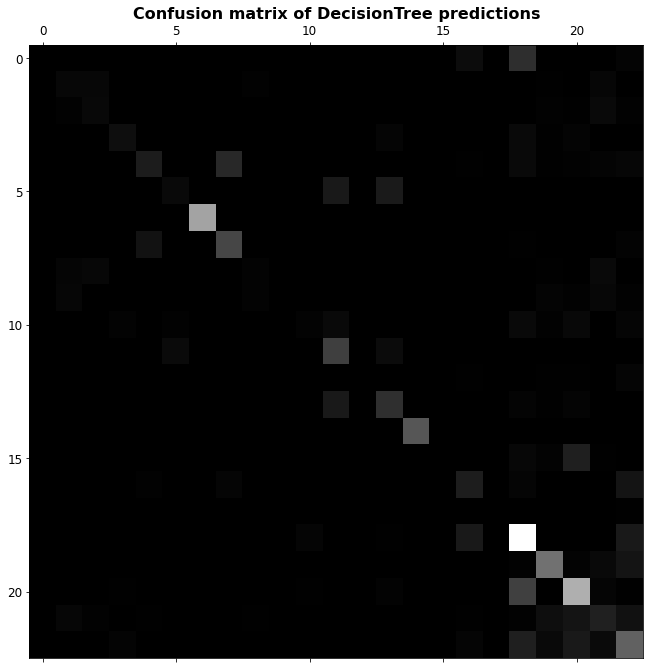

In [382]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion matrix of DecisionTree predictions", weight='bold', size = '16')

plt.show()

C:\Users\Jarl\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


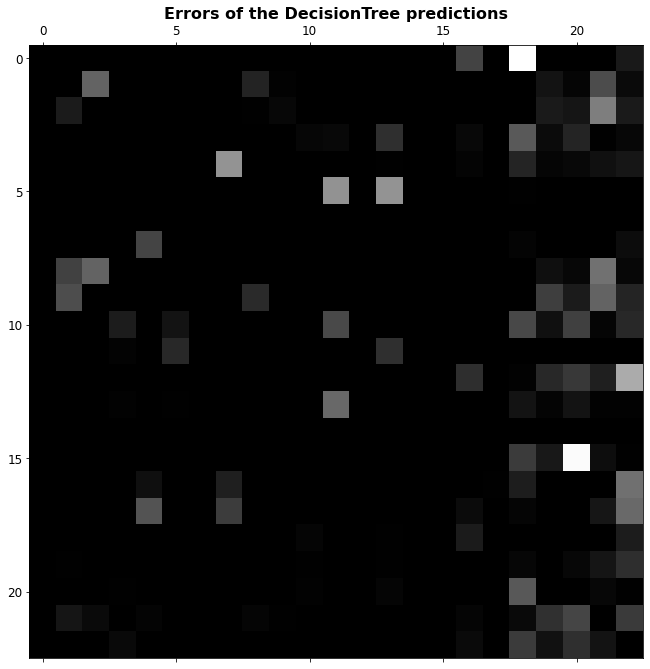

In [381]:
# we fill the diagonal with zeros to plot the errors

sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Errors of the DecisionTree predictions", weight="bold", size=16)
plt.show()

In [407]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

prec_score = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec_score = recall_score(y_test, y_pred, average="weighted", zero_division=0)
F1_score = f1_score(y_test, y_pred, average="weighted", zero_division=0)
acc_score = accuracy_score(y_test, y_pred)

print(f'The accuracy of the model is {acc_score}, using weighted average.')
print(f'The precision of the model is {prec_score}, using weighted average.')
print(f'The recall of the model is {rec_score}, using weighted average.')
print(f'The f1-score of the model is {F1_score}, using weighted average.')

The accuracy of the model is 0.588505258039025, using weighted average.
The precision of the model is 0.5444393612446777, using weighted average.
The recall of the model is 0.588505258039025, using weighted average.
The f1-score of the model is 0.5545579196278956, using weighted average.


In [423]:
df_result = X_test.copy()
df_result['predicted_next_event'] = y_pred

In [425]:
df_result['event concept:name'] = event_encoder.inverse_transform(df_result['event concept:name'])
df_result['predicted_next_event'] = event_encoder.inverse_transform(df_result['predicted_next_event'])

In [426]:
df_result.head()

,case AMOUNT_REQ,event concept:name,time of day,predicted_next_event
209775,13000,A_CANCELLED,143869.0,O_CANCELLED
209776,13000,O_CREATED,143869.0,O_SELECTED
209777,13000,W_Valideren aanvraag,143882.0,W_Nabellen offertes
209778,6000,W_Nabellen offertes,144220.0,W_Nabellen incomplete dossiers
209779,4400,W_Nabellen incomplete dossiers,1323.0,W_Completeren aanvraag
